# Vertex AI - Experiments > Studies (Vizier)
## Using Vertex Vizier

Reference:
- Based on: https://cloud.google.com/vertex-ai/docs/vizier/using-vizier#without-final-measurement

---
## Setup

In [27]:
!pip install plotly -q

In [1]:
from google.cloud import aiplatform_v1beta1 as aipv1

import plotly.graph_objects as go
import numpy as np

In [2]:
# Locations
REGION = 'us-central1'
PROJECT_ID='statmike-mlops'

ENDPOINT = REGION + "-aiplatform.googleapis.com"
PARENT ="projects/{}/locations/{}".format(PROJECT_ID, REGION)

In [3]:
vizier = aipv1.VizierServiceClient(
    client_options = {"api_endpoint" : ENDPOINT}
)

---
## Challenge
Two functions: y1, y2
What is the value of `r` and `theta` than minimizes `y1` while maximizing `y2`

In [4]:
r = np.linspace(0,1,100)
theta = np.linspace(0,np.pi/2,100)

R, THETA = np.meshgrid(r, theta)

In [5]:
blue = R * np.sin(THETA)
green = R * np.cos(THETA)

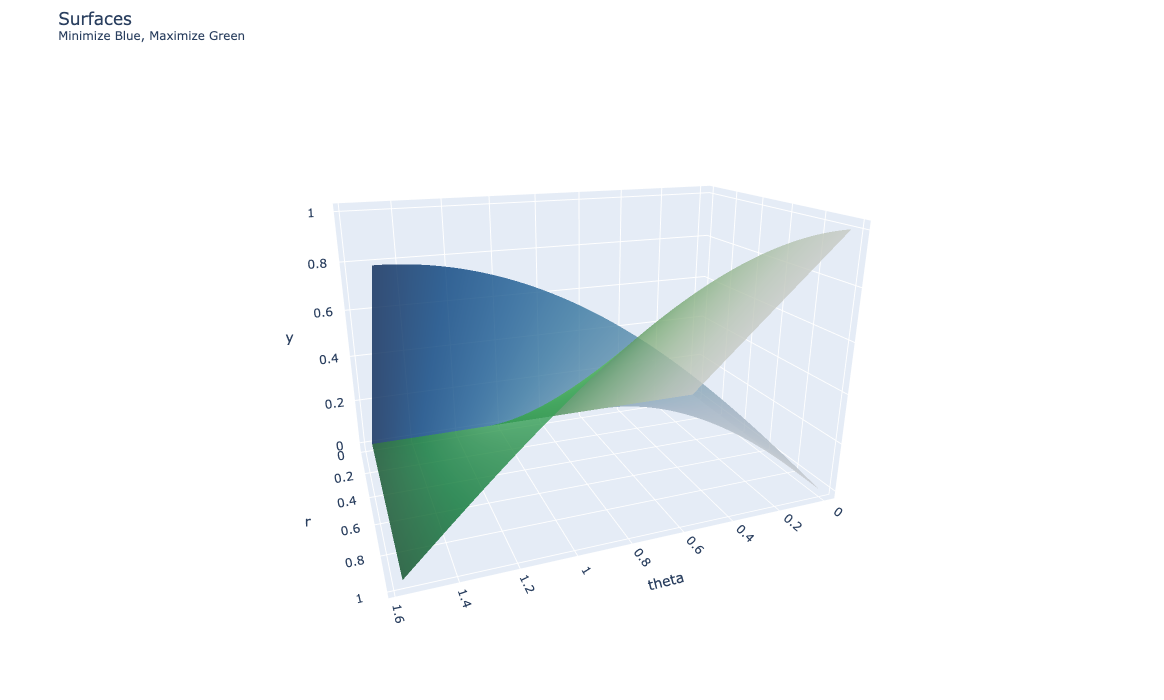

In [29]:
fig=go.Figure()
fig.add_trace(go.Surface(x=R, y=blue, z=THETA, showscale=False, opacity=0.8, colorscale='blues'))
fig.add_trace(go.Surface(x=R, y=green, z=THETA, showscale=False, opacity=0.8, colorscale='greens'))
fig.update_layout(
    title_text="Surfaces <br><sup>Minimize Blue, Maximize Green</sup>",
    scene =  dict(
        xaxis_title='r',
        yaxis_title='y',
        zaxis_title='theta'
    ),
    autosize=False,
    height=700,
    width=1200,
    margin=dict(r=10, l=10, b=50, t=50),
    scene_camera = dict(
        up=dict(x=0, y=1, z=0), # change from z=1 to y=1
        center=dict(x=0, y=0, z=0),
        eye=dict(x=2, y=.75, z=0.75) # default is 1.25 for all
    )
)

## Study

In [7]:
def make_study(algo):
    study_spec = {
        "display_name" : "CustomOpt_"+algo,
        "study_spec" : {
            "algorithm" : algo,
            "parameters" : [
                {
                    "parameter_id" : "r",
                    "double_value_spec" : {
                        "min_value" : np.min(r),
                        "max_value" : np.max(r)
                    }
                },
                {
                    "parameter_id" : "theta",
                    "double_value_spec" : {
                        "min_value" : np.min(theta),
                        "max_value" : np.max(theta)
                    }

                }
            ],
            "metrics" : [
                {
                    "metric_id" : "blue",
                    "goal" : "MINIMIZE"
                },
                {
                    "metric_id" : "green",
                    "goal" : "MAXIMIZE" 
                }
            ]
        }
    }
    study = vizier.create_study(parent=PARENT, study=study_spec)
    return study

In [8]:
study_random = make_study("RANDOM_SEARCH")

In [9]:
study_random.name, study_random.display_name

('projects/691911073727/locations/us-central1/studies/3240081905661',
 'CustomOpt_RANDOM_SEARCH')

## Evaluations

In [13]:
def blue_eval(r,theta):
    return r*np.sin(theta)

def green_eval(r,theta):
    return r*np.cos(theta)

def metrics(trial, r, theta):
    blue = blue_eval(r,theta)
    green = green_eval(r,theta)
    m1 = {"metric_id" : "blue", "value" : blue}
    m2 = {"metric_id" : "green", "value" : green}
    return [m1, m2]

## Trials

In [14]:
def trial_runner(tname, max_trials):
    trial_id = 0
    while int(trial_id) < max_trials:
        suggestions = vizier.suggest_trials(
            {
                "parent": tname,
                "suggestion_count" : 5,
                "client_id" : "client1"
            }
        )

        for suggestion in suggestions.result().trials:
            trial_id = suggestion.name.split("/")[-1]
            trial = vizier.get_trial({"name" : suggestion.name})

            if trial.state in ["COMPLETED", "INFEASIBLE"]:
                continue

            for param in trial.parameters:
                if param.parameter_id == "r": 
                    r = param.value
                elif param.parameter_id == "theta":
                    theta = param.value

            vizier.add_trial_measurement(
                {
                    "trial_name": suggestion.name,
                    "measurement": {
                        "metrics": metrics(suggestion.name, r, theta)
                    }               
                }
            )

            response = vizier.complete_trial(
                {
                    "name" : suggestion.name,
                    "trial_infeasible": False
                }
            )

In [15]:
trial_runner(study_random.name, 100)

## Answers

In [16]:
def plot_result(study):
    fig=go.Figure()
    fig.add_trace(go.Surface(x=R, y=blue, z=THETA, showscale=False, opacity=0.8, colorscale='blues'))
    fig.add_trace(go.Surface(x=R, y=green, z=THETA, showscale=False, opacity=0.8, colorscale='greens'))

    trials = vizier.list_trials({"parent": study.name})
    try_r = [x.parameters[0].value for x in trials.trials]
    try_theta = [x.parameters[1].value for x in trials.trials]
    try_blue = [x.measurements[0].metrics[0].value for x in trials.trials]
    try_green = [x.measurements[0].metrics[1].value for x in trials.trials]
    for i, j, k, h in zip(try_r, try_theta, try_blue, try_green):
        fig.add_trace(go.Scatter3d(x=[i,i], y=[k,h], z=[j,j], mode='lines+markers', line=dict(color="#ff0000"), marker=dict(size=5)))

    fig.update_layout(
        title_text="Surfaces <br><sup>Minimize Blue, Maximize Green</sup>",
        showlegend=False,
        scene =  dict(
            xaxis_title='r',
            yaxis_title='y',
            zaxis_title='theta'
        ),
        autosize=False,
        height=700,
        width=1200,
        margin=dict(r=10, l=10, b=50, t=50),
        scene_camera = dict(
            up=dict(x=0, y=1, z=0), # change from z=1 to y=1
            center=dict(x=0, y=0, z=0),
            eye=dict(x=2, y=.75, z=0.75) # default is 1.25 for all
        )
    )
    fig.show()

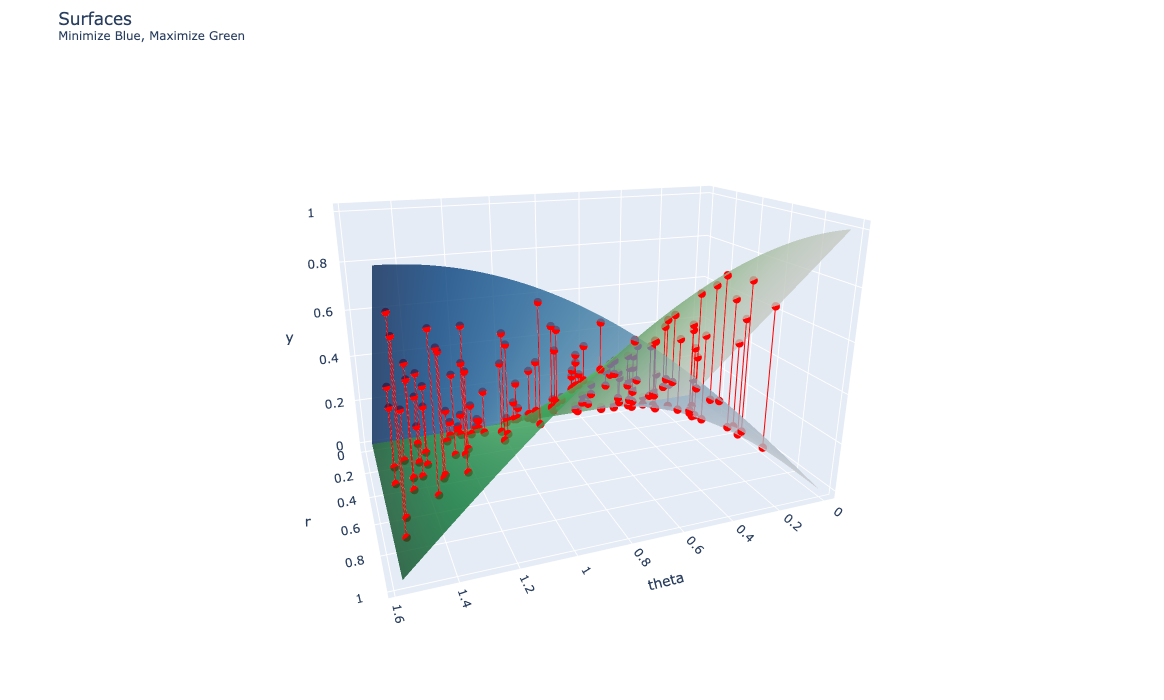

In [30]:
plot_result(study_random)

Optimal answer (so far ....):

In [18]:
def optimals(study):
    otrials = vizier.list_optimal_trials({"parent": study.name})
    print("r = {}".format(otrials.optimal_trials[-1].parameters[0].value))
    print("theta = {}".format(otrials.optimal_trials[-1].parameters[1].value))
    print("blue = {}".format(otrials.optimal_trials[-1].measurements[0].metrics[0].value))
    print("green = {}".format(otrials.optimal_trials[-1].measurements[0].metrics[1].value))
    print("Trial ID = {}".format(otrials.optimal_trials[-1].name.split("/")[-1]))

In [19]:
optimals(study_random)

r = 0.6339591847029411
theta = 0.01067542561568343
blue = 0.0067676555723132905
green = 0.6339230605580399
Trial ID = 92


## Vizier Algorithm

In [20]:
study_viz = make_study("ALGORITHM_UNSPECIFIED") # unspecified means use the default = Vizier

In [21]:
trial_runner(study_viz.name, 100)

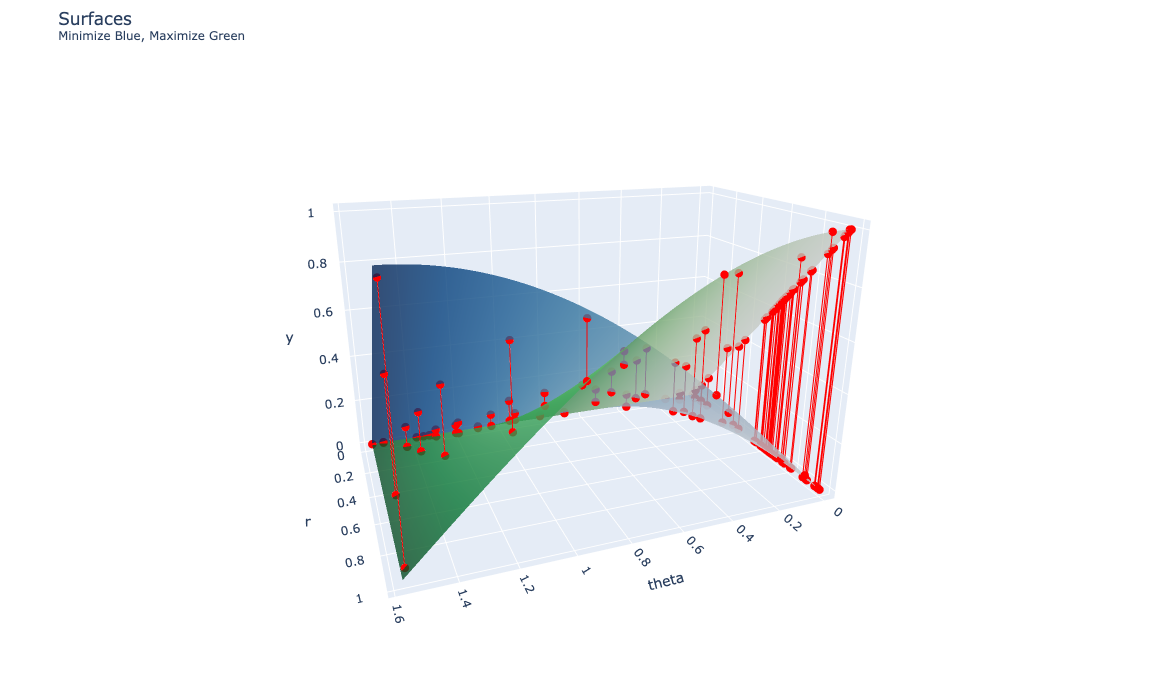

In [31]:
plot_result(study_viz)

In [23]:
optimals(study_viz)

r = 1.0
theta = 0.0
blue = 0.0
green = 1.0
Trial ID = 17


---
## Remove Resources
see notebook "XX - Cleanup"